# Imports

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [8]:
import pytorch_lightning as pl
import lightning as L

from torchmetrics import Precision, Recall, F1Score
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# Data: FashionMNIST

## utils

In [12]:
def imshow(img):
    img = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

val_set = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [11]:
for images, labels in train_loader:
    break

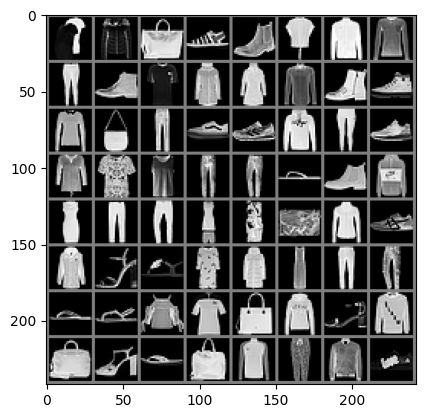

In [16]:
grid_img = torchvision.utils.make_grid(images, nrow=8)
imshow(grid_img)

In [22]:
images.shape

torch.Size([64, 1, 28, 28])

In [19]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Model

## simple cnn

In [42]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = ConvBnRelu(1, 32, 3, 1)
        self.conv2 = ConvBnRelu(32, 64, 3, 1)
        self.conv3 = ConvBnRelu(64, 96, 3, 1)

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False), # bias false, using bn
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),

        )

        self.neck = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(128, 10),
        )
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)
        return x

In [43]:
simple_cnn = SimpleCNN()

In [44]:
out = simple_cnn(images)

/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Spatial attention

In [52]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [55]:
class SpatialAttentionCNN(nn.Module):
    def __init__(self):
        super(SpatialAttentionCNN, self).__init__()
        self.conv1 = ConvBnRelu(1, 32, 3, 1)
        self.conv2 = ConvBnRelu(32, 64, 3, 1)
        self.conv3 = ConvBnRelu(64, 96, 3, 1)

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False), # bias false, using bn
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),

        )

        self.sa = SpatialAttention()

        self.neck = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(128, 10),
        )
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.sa(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

In [56]:
sa_cnn = SpatialAttentionCNN()

In [58]:
sa_cnn(images).shape

torch.Size([64, 10])

# Training loop

In [69]:
class LModule(L.LightningModule):
    def __init__(self, model: nn.Module):
        super(LModule, self).__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        
        self.precision_micro = Precision('multiclass', num_classes=10, average='micro')
        self.precision_macro = Precision('multiclass', num_classes=10, average='macro')
        self.recall_micro = Recall('multiclass', num_classes=10, average='micro')
        self.recall_macro = Recall('multiclass', num_classes=10, average='macro')
        self.f1_micro = F1Score('multiclass', num_classes=10, average='micro')
        self.f1_macro = F1Score('multiclass', num_classes=10, average='macro')
        

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.loss(outputs, labels)
        self.log('loss/train', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.loss(outputs, labels)
        
        self.log('loss/val', loss)
        preds = torch.argmax(outputs, dim=1)
        
        self.precision_micro(preds, labels)
        self.recall_micro(preds, labels)
        self.f1_micro(preds, labels)
        self.precision_macro(preds, labels)
        self.recall_macro(preds, labels)
        self.f1_macro(preds, labels)

    def on_validation_epoch_end(self, outputs):
        self.log('val/micro_precision', self.precision_micro.compute(), prog_bar=True)
        self.log('val/macro_precision', self.precision_macro.compute(), prog_bar=True)
        self.log('val/micro_recall', self.recall_micro.compute(), prog_bar=True)
        self.log('val/macro_recall', self.recall_macro.compute(), prog_bar=True)
        self.log('val/micro_f1', self.f1_micro.compute(), prog_bar=True)
        self.log('val/macro_f1', self.f1_macro.compute(), prog_bar=True)


    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-4)

In [70]:
module = LModule(simple_cnn)

trainer = L.Trainer(max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module)

Missing logger folder: /Users/timur/Documents/itmo_master/1_term/image_processing_itmo/hw1/lightning_logs
